# Alloys Property Predictions by ML 

#### Here we are experimenting with various ML and Deep Learning models to predict Physical Properties of Alloys for their Chemical Composition [C2P] and reverse also [P2C]
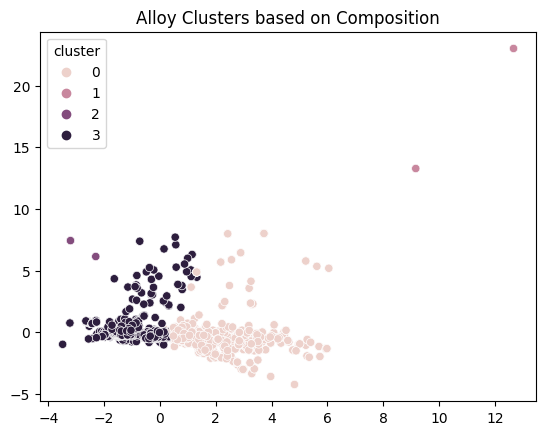 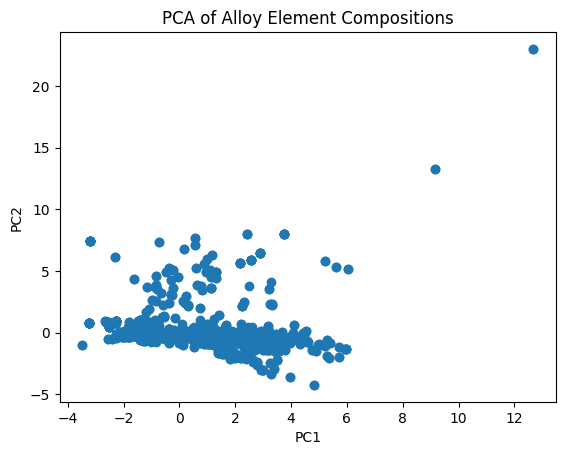
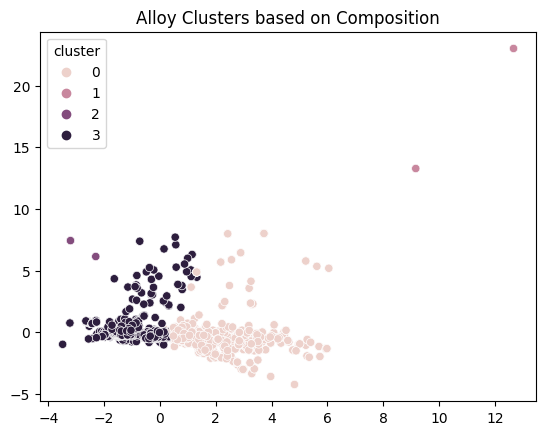
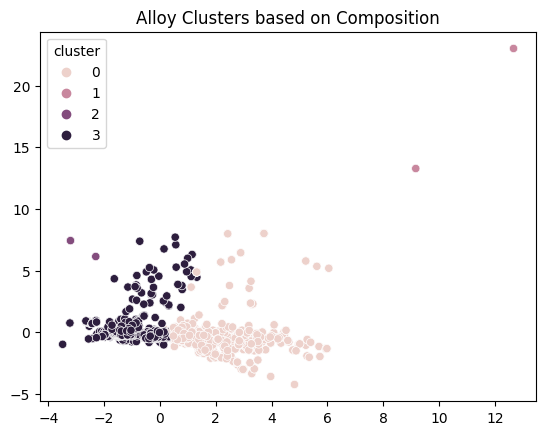
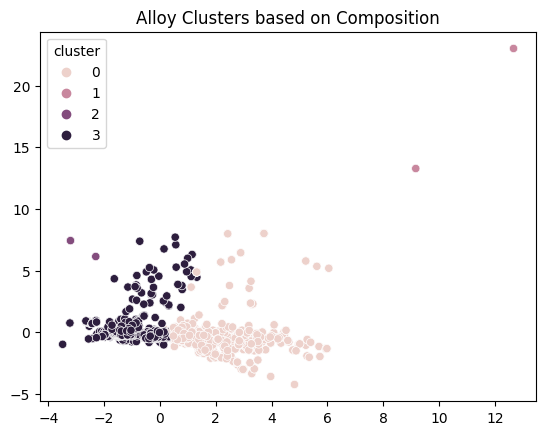
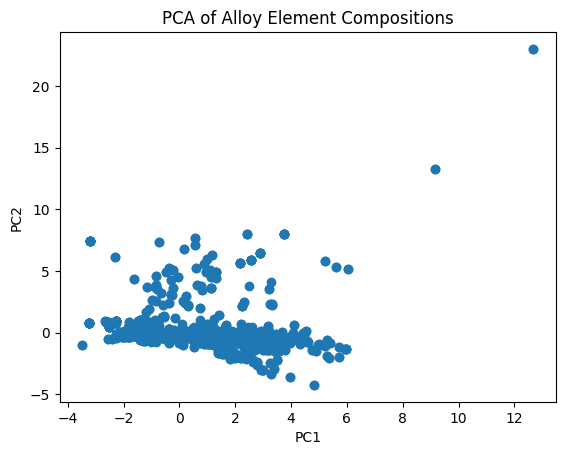

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA

## Building the DataSet

In [ ]:
### superalloys dataset
dfsa = pd.read_csv('/kaggle/input/superalloys/selestedsuperalloy.csv')

print("Original DataFrame:")
print(dfsa.head()) 

print()
print()
print()

print("columns=> ")
dfsa.columns

In [ ]:
### iron alloy dataset
dfia = pd.read_csv('/kaggle/input/iron-alloy/Iron_Scrape.csv')

print("Original DataFrame:")
print(dfia.head()) 

print()
print()
print()

print("columns=> ")
dfia.columns

In [ ]:
### iron alloy dataset
dfiad = pd.read_csv('/kaggle/input/iron-alloys-dataset/iron_alloys.csv')

print("Original DataFrame:")
print(dfiad.head()) 

print()
print()
print()

print("columns=> ")
dfiad.columns

here we are merging both the dataset with col </br>
**iron alloys csv** </br>
I. Tensile Strength: Ultimate (UTS)  </br>
II. Melting Completion (Liquidus) </br>
</br>
**iron alloy dataset csv** </br>
I. Tensile Strength: Ultimate (UTS) (psi) </br>
II. Melting Completion (Liquidus) (F) </br>

In [ ]:
print(dfia.columns.tolist())

In [ ]:
print(dfiad.columns.tolist())

In [ ]:
import re
def extract_symbol(col):
    # capture element symbol in parentheses, e.g. "Cerium (Ce)Ce" -> "Ce"
    m = re.search(r"\(([^)]+)\)", col)
    return m.group(1) if m else col

In [ ]:
ia = dfia
iad = dfiad

In [ ]:
# 2. Standardize element columns in IA (ia) to symbols only
def extract_symbol(col_name):
    """Extract element symbol from strings like 'Cerium (Ce)Ce' or leave others unchanged."""
    m = re.search(r"\(([^)]+)\)", col_name)
    return m.group(1) if m else col_name

# Rename IA columns: element columns -> symbols; physical properties -> unified names
ia_rename_map = {}
for col in ia.columns:
    if col in ['Tensile Strength: Ultimate (UTS)', 'Melting Completion (Liquidus)']:
        # map to short names
        ia_rename_map[col] = 'UTS' if 'Ultimate' in col else 'Liquidus'
    else:
        # attempt extract element symbol
        sym = extract_symbol(col)
        ia_rename_map[col] = sym

ia = ia.rename(columns=ia_rename_map)

In [ ]:
ia.columns.tolist()

In [ ]:
# Clean IA element values: convert ranges like '2 to 4' → mean (3), cast others to float
def parse_val(v):
    if pd.isna(v):
        return None
    if isinstance(v, str) and 'to' in v:
        # extract all numbers and average
        nums = re.findall(r"[-+]?[0-9]*\.?[0-9]+", v)
        nums = list(map(float, nums))
        return sum(nums) / len(nums) if nums else None
    try:
        return float(v)
    except:
        return None

# identify IA element cols (exclude 'Alloy' fields)
ia_elem_cols = [c for c in ia.columns if c not in ['Names', 'UTS', 'Liquidus']]
for col in ia_elem_cols:
    ia[col] = ia[col].apply(parse_val)

In [ ]:
# Process IAD: combine min and max of each element into mean and rename phys props
# Identify element symbols by finding columns ending with 'min' or 'max'
element_symbols = set()
for col in iad.columns:
    # match pattern like 'Iron (Fe)Fe min' or 'Iron (Fe)Fe max'
    m = re.match(r"^.+\(([^)]+)\).+ (min|max)$", col)
    if m:
        element_symbols.add(m.group(1))

# For each symbol, find its min/max columns and compute mean
for sym in element_symbols:
    min_col = f"{sym} min"
    max_col = f"{sym} max"
    # fallback if original names differ
    # search any col containing sym and ending with min/max
iad_cols = iad.columns.tolist()
for sym in element_symbols:
    # collect matching cols
    matched = [c for c in iad_cols if f"({sym})" in c and c.endswith(('min', 'max'))]
    if len(matched) == 2:
        iad[sym] = iad[matched].mean(axis=1)

# Rename physical properties in IAD
iad_rename_map = {
    "Tensile Strength: Ultimate (UTS) (psi)": 'UTS',
    'Melting Completion (Liquidus) (F)': 'Liquidus'
}
iad = iad.rename(columns=iad_rename_map)


In [ ]:
iad.columns.tolist()

In [ ]:
len(element_symbols)

**merging - full outer join, keep every row from both ia_sel and iad_sel </br>
matches rows where all of the specified key columns (Alloy, UTS, Liquidus, plus each element symbol) are exactly equal.**

In [ ]:
# Select only relevant columns: alloy name, UTS, Liquidus, and element symbols
# Determine name column in each df
name_col_ia = 'Names'
name_col_iad = 'iron_alloy_name'

element_list = sorted(element_symbols)
keep_ia = [name_col_ia, 'UTS', 'Liquidus'] + element_list
keep_iad = [name_col_iad, 'UTS', 'Liquidus'] + element_list

ia_sel = ia[keep_ia]
iad_sel = iad[keep_iad]

# Harmonize name column and merge outer on alloy name
ia_sel = ia_sel.rename(columns={name_col_ia: 'Alloy'})
iad_sel = iad_sel.rename(columns={name_col_iad: 'Alloy'})

# Convert UTS and Liquidus to floats (coercing any bad values to NaN)
ia_sel['UTS'] = pd.to_numeric(ia_sel['UTS'], errors='coerce')
iad_sel['UTS'] = pd.to_numeric(iad_sel['UTS'], errors='coerce')

ia_sel['Liquidus'] = pd.to_numeric(ia_sel['Liquidus'], errors='coerce')
iad_sel['Liquidus'] = pd.to_numeric(iad_sel['Liquidus'], errors='coerce')


combined = pd.merge(
    ia_sel,
    iad_sel,
    on=['Alloy', 'UTS', 'Liquidus'] + element_list,
    how='outer',
    suffixes=('_ia', '_iad')
)

# Save combined CSV
combined.to_csv('combined_iron_alloys.csv', index=False)
print("Merged dataset saved to 'combined_iron_alloys.csv'")

In [ ]:
# 8. Row-wise sum of element values (cols after first three)
# Treat missing as zero (already applied), compute sum
element_sums = combined[element_list].sum(axis=1)
combined['ElementSum'] = element_sums

# 9. Drop rows where ElementSum is exactly zero
combined = combined[combined['ElementSum'] != 0]

# 10. Compute statistics of ElementSum
de_stats = element_sums[element_sums != 0].describe()
print("ElementSum statistics (count, mean, std, min, 25%, 50%, 75%, max):")
print(de_stats)

# 11. Save result
combined.to_csv('Final_alloys.csv', index=False)
print("Merged dataset (with non-zero element sums) saved to 'Final_alloys.csv'")


### **We got the Alloy data of 2672 alloys their compositions and 2 physical properties >>>** 

In [ ]:
df.rename(columns={'UTS': 'Tensile Strength: Ultimate (UTS) (psi)', 'Liquidus': 'Melting Completion (Liquidus)'}, inplace=True)
df.to_csv('Final_alloys.csv', index=False)

## EDA

### DATA Cleaning

In [2]:
### superalloys dataset
df = pd.read_csv('/kaggle/working/Final_alloys.csv')

print("Original DataFrame:")
print(df.head()) 

print()
print()
print()

print("columns=> ")
df.columns

Original DataFrame:
                                               Alloy  \
0   ACI-ASTM CA15 (SCS1,J91150) Cast Stainless Steel   
1       ACI-ASTM CA15M (J91151) Cast Stainless Steel   
2     ACI-ASTM CA28MWV (J91422) Cast Stainless Steel   
3  ACI-ASTM CA40 (SCS2A,J91153) Cast Stainless Steel   
4       ACI-ASTM CA40F (J91154) Cast Stainless Steel   

   Tensile Strength: Ultimate (UTS) (psi)  Melting Completion (Liquidus)  Al  \
0                                   700.0                         1440.0 NaN   
1                                   690.0                         1450.0 NaN   
2                                  1080.0                         1470.0 NaN   
3                                   910.0                         1440.0 NaN   
4                                   770.0                         1430.0 NaN   

   As   B      C  Ca  Ce  Co  ...  Se     Si  Sn  Ta  Ti     V    W  Zn  Zr  \
0 NaN NaN  0.075 NaN NaN NaN  ... NaN  0.750 NaN NaN NaN   NaN  NaN NaN NaN   
1 Na

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Index(['Alloy', 'Tensile Strength: Ultimate (UTS) (psi)',
       'Melting Completion (Liquidus)', 'Al', 'As', 'B', 'C', 'Ca', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'La', 'Mg', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'O', 'P',
       'Pb', 'S', 'Se', 'Si', 'Sn', 'Ta', 'Ti', 'V', 'W', 'Zn', 'Zr',
       'ElementSum'],
      dtype='object')

In [3]:
df = df.drop('ElementSum', axis=1)

In [4]:
null_counts = df.isnull().sum()

print("Null values in each column:")
print(null_counts)

Null values in each column:
Alloy                                        0
Tensile Strength: Ultimate (UTS) (psi)     469
Melting Completion (Liquidus)                0
Al                                        2270
As                                        2661
B                                         2498
C                                           18
Ca                                        2644
Ce                                        2652
Co                                        2563
Cr                                         522
Cu                                        1586
Fe                                           0
La                                        2664
Mg                                        2652
Mn                                          30
Mo                                        1022
N                                         1876
Nb                                        2252
Ni                                         876
O                               

In [5]:
df['Tensile Strength: Ultimate (UTS) (psi)'].fillna(df['Tensile Strength: Ultimate (UTS) (psi)'].mean(), inplace=True)
null_counts = df.isnull().sum()

print("Null values in each column:")
print(null_counts)

Null values in each column:
Alloy                                        0
Tensile Strength: Ultimate (UTS) (psi)       0
Melting Completion (Liquidus)                0
Al                                        2270
As                                        2661
B                                         2498
C                                           18
Ca                                        2644
Ce                                        2652
Co                                        2563
Cr                                         522
Cu                                        1586
Fe                                           0
La                                        2664
Mg                                        2652
Mn                                          30
Mo                                        1022
N                                         1876
Nb                                        2252
Ni                                         876
O                               

/tmp/ipykernel_35/3079390845.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tensile Strength: Ultimate (UTS) (psi)'].fillna(df['Tensile Strength: Ultimate (UTS) (psi)'].mean(), inplace=True)


In [6]:
df.fillna(0, inplace=True)
null_counts = df.isnull().sum()

print("Null values in each column:")
print(null_counts)

df.head()

Null values in each column:
Alloy                                     0
Tensile Strength: Ultimate (UTS) (psi)    0
Melting Completion (Liquidus)             0
Al                                        0
As                                        0
B                                         0
C                                         0
Ca                                        0
Ce                                        0
Co                                        0
Cr                                        0
Cu                                        0
Fe                                        0
La                                        0
Mg                                        0
Mn                                        0
Mo                                        0
N                                         0
Nb                                        0
Ni                                        0
O                                         0
P                                         0
Pb  

,Alloy,Tensile Strength: Ultimate (UTS) (psi),Melting Completion (Liquidus),Al,As,B,C,Ca,Ce,Co,...,S,Se,Si,Sn,Ta,Ti,V,W,Zn,Zr
0,"ACI-ASTM CA15 (SCS1,J91150) Cast Stainless Steel",700.0,1440.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,...,0.020,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,ACI-ASTM CA15M (J91151) Cast Stainless Steel,690.0,1450.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,...,0.020,0.0,0.325,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,ACI-ASTM CA28MWV (J91422) Cast Stainless Steel,1080.0,1470.0,0.0,0.0,0.0,0.240,0.0,0.0,0.0,...,0.015,0.0,0.500,0.0,0.0,0.0,0.25,1.1,0.0,0.0
3,"ACI-ASTM CA40 (SCS2A,J91153) Cast Stainless Steel",910.0,1440.0,0.0,0.0,0.0,0.300,0.0,0.0,0.0,...,0.020,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,ACI-ASTM CA40F (J91154) Cast Stainless Steel,770.0,1430.0,0.0,0.0,0.0,0.300,0.0,0.0,0.0,...,0.300,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [ ]:
df.to_csv('Alloys.csv', index=False)

### **Alloys.csv is the final Cleaned dataset that we will be using**

In [7]:
df = pd.read_csv('/kaggle/working/Alloys.csv')
df.head()

,Alloy,Tensile Strength: Ultimate (UTS) (psi),Melting Completion (Liquidus),Al,As,B,C,Ca,Ce,Co,...,S,Se,Si,Sn,Ta,Ti,V,W,Zn,Zr
0,"ACI-ASTM CA15 (SCS1,J91150) Cast Stainless Steel",700.0,1440.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,...,0.020,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,ACI-ASTM CA15M (J91151) Cast Stainless Steel,690.0,1450.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,...,0.020,0.0,0.325,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,ACI-ASTM CA28MWV (J91422) Cast Stainless Steel,1080.0,1470.0,0.0,0.0,0.0,0.240,0.0,0.0,0.0,...,0.015,0.0,0.500,0.0,0.0,0.0,0.25,1.1,0.0,0.0
3,"ACI-ASTM CA40 (SCS2A,J91153) Cast Stainless Steel",910.0,1440.0,0.0,0.0,0.0,0.300,0.0,0.0,0.0,...,0.020,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,ACI-ASTM CA40F (J91154) Cast Stainless Steel,770.0,1430.0,0.0,0.0,0.0,0.300,0.0,0.0,0.0,...,0.300,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [8]:
df.columns.tolist()

['Alloy',
 'Tensile Strength: Ultimate (UTS) (psi)',
 'Melting Completion (Liquidus)',
 'Al',
 'As',
 'B',
 'C',
 'Ca',
 'Ce',
 'Co',
 'Cr',
 'Cu',
 'Fe',
 'La',
 'Mg',
 'Mn',
 'Mo',
 'N',
 'Nb',
 'Ni',
 'O',
 'P',
 'Pb',
 'S',
 'Se',
 'Si',
 'Sn',
 'Ta',
 'Ti',
 'V',
 'W',
 'Zn',
 'Zr']

In [9]:
df.info()
df.describe()
df.shape
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Data columns (total 33 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Alloy                                   2672 non-null   object 
 1   Tensile Strength: Ultimate (UTS) (psi)  2672 non-null   float64
 2   Melting Completion (Liquidus)           2672 non-null   float64
 3   Al                                      2672 non-null   float64
 4   As                                      2672 non-null   float64
 5   B                                       2672 non-null   float64
 6   C                                       2672 non-null   float64
 7   Ca                                      2672 non-null   float64
 8   Ce                                      2672 non-null   float64
 9   Co                                      2672 non-null   float64
 10  Cr                                      2672 non-null   floa

Alloy                                     0
Tensile Strength: Ultimate (UTS) (psi)    0
Melting Completion (Liquidus)             0
Al                                        0
As                                        0
B                                         0
C                                         0
Ca                                        0
Ce                                        0
Co                                        0
Cr                                        0
Cu                                        0
Fe                                        0
La                                        0
Mg                                        0
Mn                                        0
Mo                                        0
N                                         0
Nb                                        0
Ni                                        0
O                                         0
P                                         0
Pb                              

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


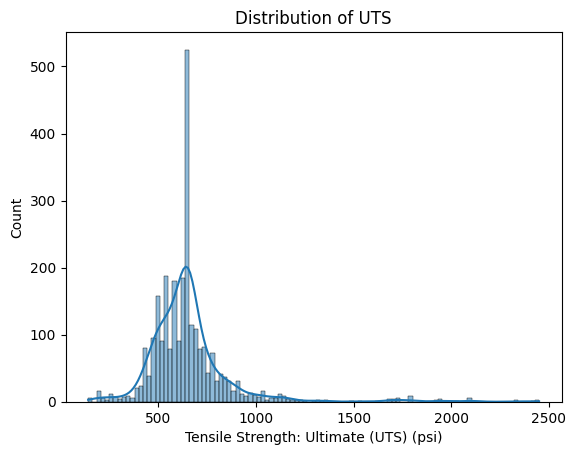

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


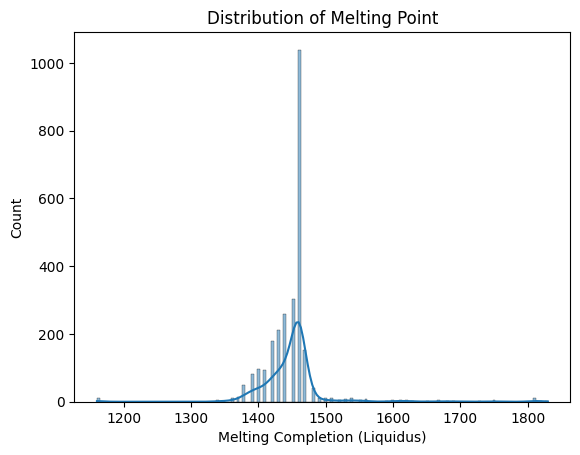

In [10]:
sns.histplot(df['Tensile Strength: Ultimate (UTS) (psi)'], kde=True)
plt.title('Distribution of UTS')
plt.show()

sns.histplot(df['Melting Completion (Liquidus)'], kde=True)
plt.title('Distribution of Melting Point')
plt.show()

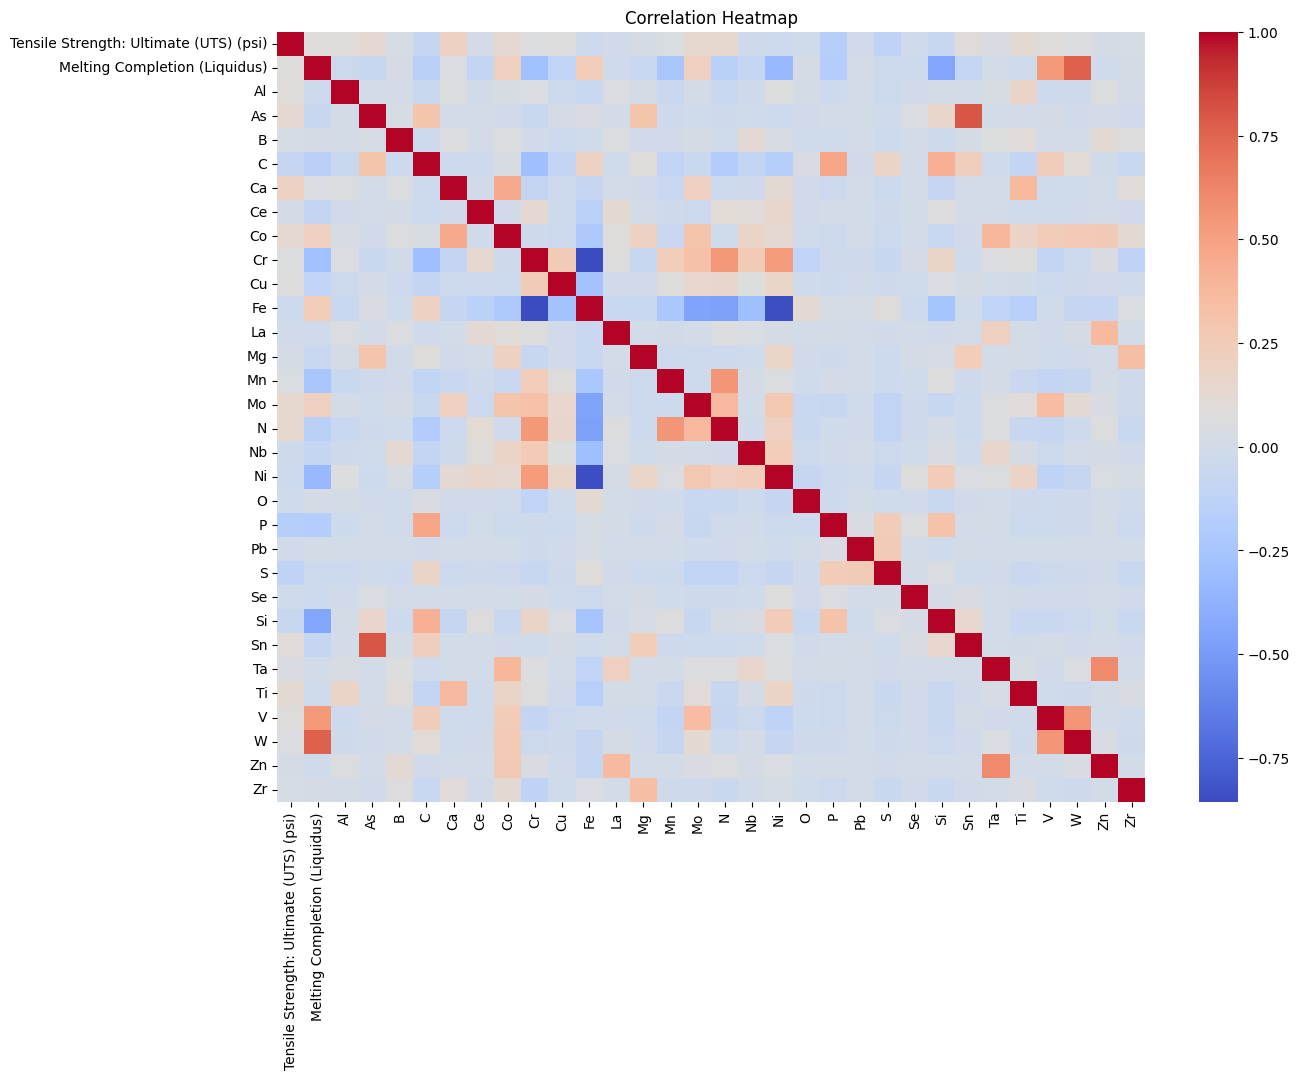

In [11]:
corr = df.drop(columns=['Alloy']).corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [12]:
corr[['Tensile Strength: Ultimate (UTS) (psi)', 'Melting Completion (Liquidus)']].sort_values(by='Tensile Strength: Ultimate (UTS) (psi)', ascending=False)

,Tensile Strength: Ultimate (UTS) (psi),Melting Completion (Liquidus)
Tensile Strength: Ultimate (UTS) (psi),1.000000,0.084887
Ca,0.198436,0.048227
N,0.144062,-0.156251
Mo,0.143746,0.218097
Co,0.134438,0.216913
As,0.133395,-0.069442
Ti,0.116218,-0.019054
Sn,0.094213,-0.083778
Al,0.089282,-0.044553
V,0.085115,0.533462


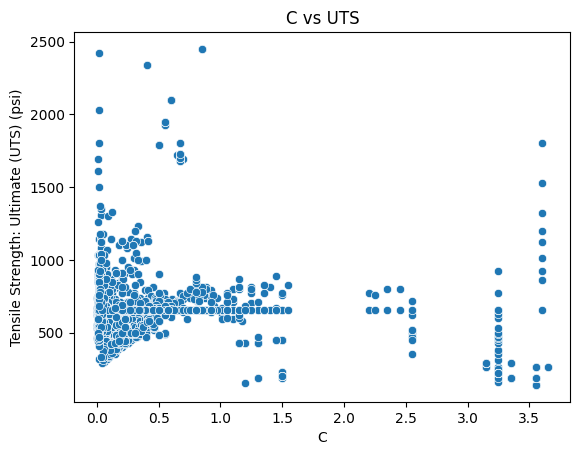

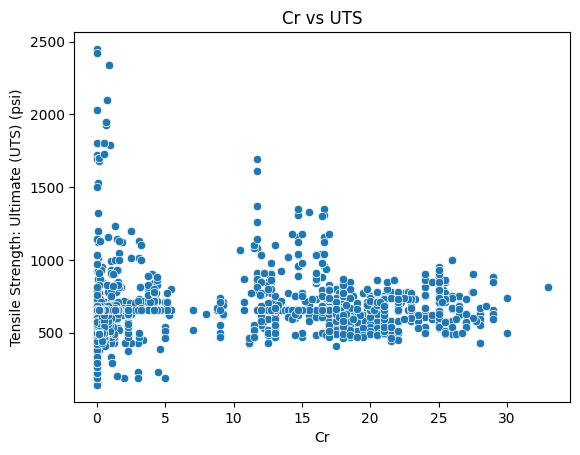

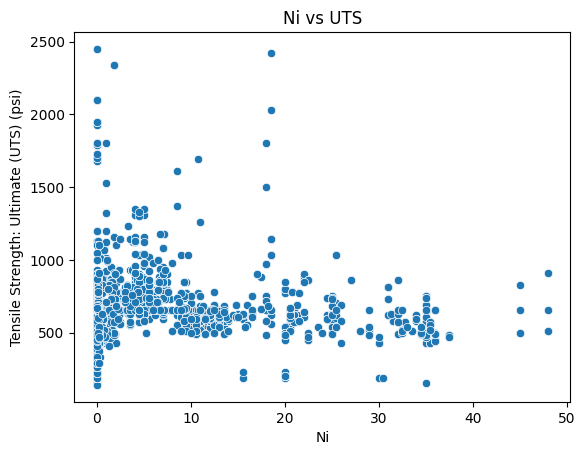

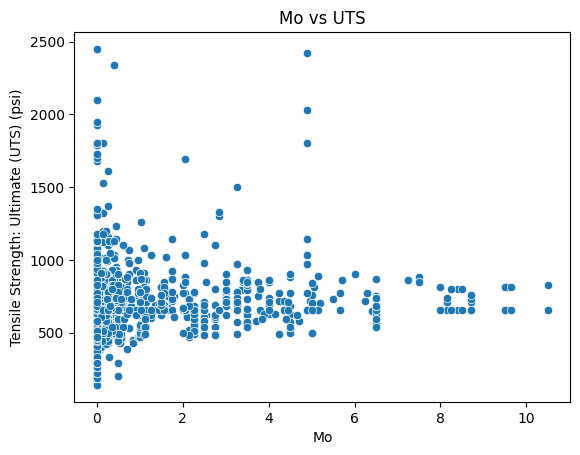

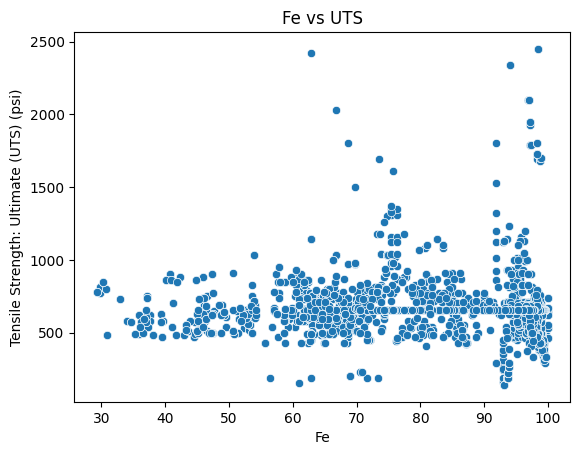

In [13]:
for element in ['C', 'Cr', 'Ni', 'Mo', 'Fe']:
    sns.scatterplot(data=df, x=element, y='Tensile Strength: Ultimate (UTS) (psi)')
    plt.title(f'{element} vs UTS')
    plt.show()

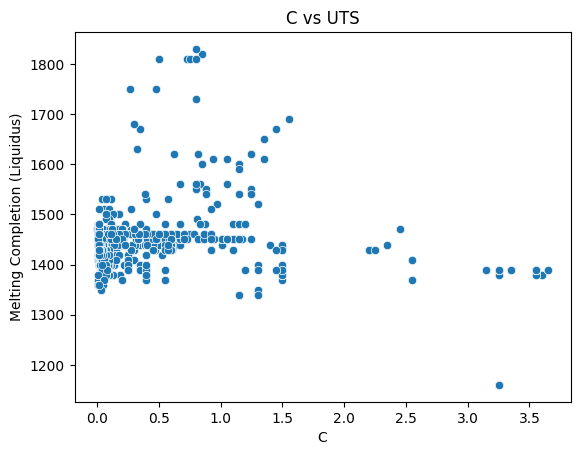

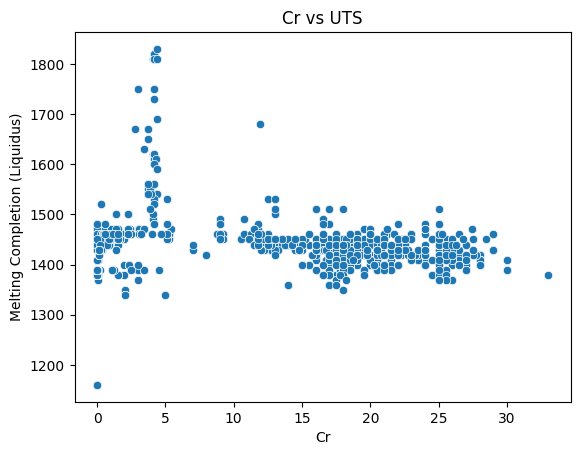

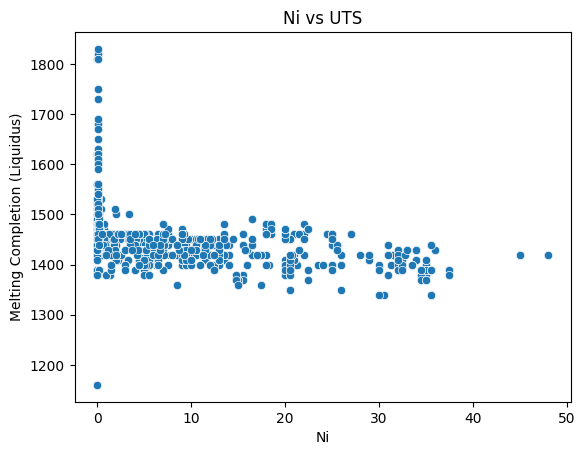

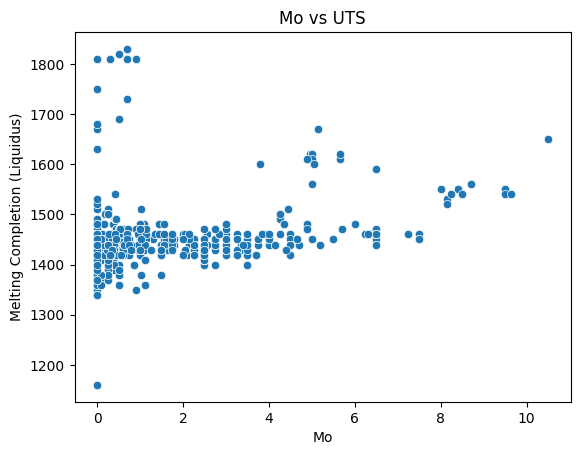

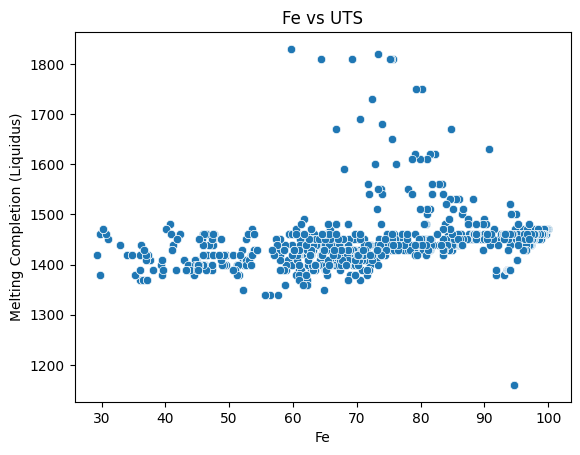

In [14]:
for element in ['C', 'Cr', 'Ni', 'Mo', 'Fe']:
    sns.scatterplot(data=df, x=element, y='Melting Completion (Liquidus)')
    plt.title(f'{element} vs UTS')
    plt.show()

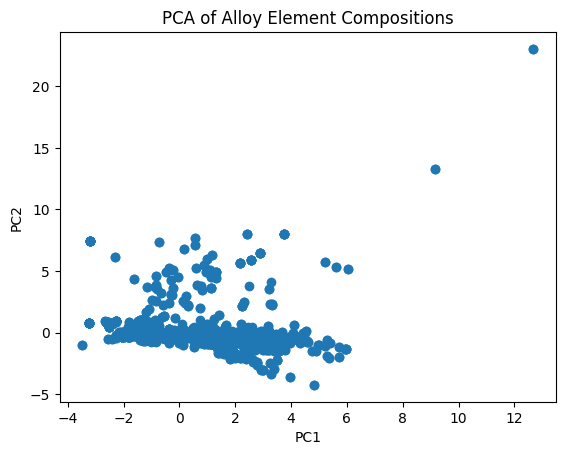

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Alloy', 'Tensile Strength: Ultimate (UTS) (psi)', 'Melting Completion (Liquidus)'])
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of Alloy Element Compositions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


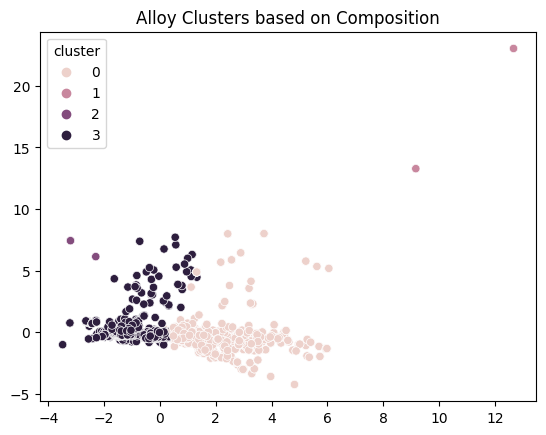

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df['cluster'])
plt.title('Alloy Clusters based on Composition')
plt.show()


<Axes: >

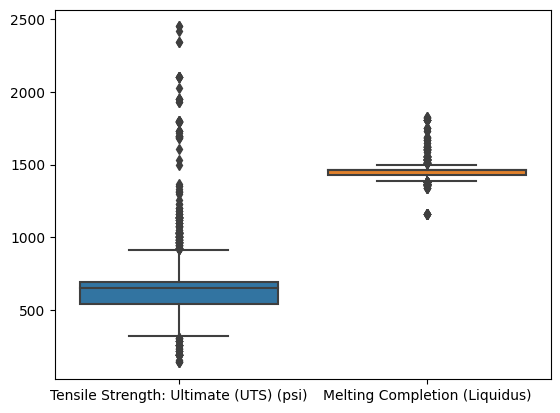

In [17]:
## outliers
sns.boxplot(data=df[['Tensile Strength: Ultimate (UTS) (psi)', 'Melting Completion (Liquidus)']])

## Train Test

In [18]:
df = pd.read_csv('/kaggle/working/Alloys.csv')
df = df.drop('Alloy', axis=1)
df.head()

,Tensile Strength: Ultimate (UTS) (psi),Melting Completion (Liquidus),Al,As,B,C,Ca,Ce,Co,Cr,...,S,Se,Si,Sn,Ta,Ti,V,W,Zn,Zr
0,700.0,1440.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,12.75,...,0.020,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,690.0,1450.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,12.75,...,0.020,0.0,0.325,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,1080.0,1470.0,0.0,0.0,0.0,0.240,0.0,0.0,0.0,11.75,...,0.015,0.0,0.500,0.0,0.0,0.0,0.25,1.1,0.0,0.0
3,910.0,1440.0,0.0,0.0,0.0,0.300,0.0,0.0,0.0,12.75,...,0.020,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,770.0,1430.0,0.0,0.0,0.0,0.300,0.0,0.0,0.0,12.75,...,0.300,0.0,0.750,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [19]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Tensile Strength: Ultimate (UTS) (psi)', 'Melting Completion (Liquidus)'])
y = df[['Tensile Strength: Ultimate (UTS) (psi)', 'Melting Completion (Liquidus)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

## Standardize the Variables

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **For Tensile Strength: Ultimate (UTS) (psi)**

In [21]:
y_train_UTS = y_train['Tensile Strength: Ultimate (UTS) (psi)']
y_test_UTS  = y_test['Tensile Strength: Ultimate (UTS) (psi)']

### **Melting Completion (Liquidus)**


In [22]:
y_train_MC = y_train['Melting Completion (Liquidus)']
y_test_MC  = y_test['Melting Completion (Liquidus)']

# KNN

## KNN regression for Tensile Strength 

In [23]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

knn = KNeighborsRegressor(
    n_neighbors=2,       
    weights='distance',  
    metric='euclidean'  
)


In [24]:
knn.fit(X_train_scaled, y_train_UTS)

KNeighborsRegressor(metric='euclidean', n_neighbors=2, weights='distance')

In [25]:
## predicton & evaluation
y_pred = knn.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_UTS, y_pred))
print("R² :", r2_score(y_test_UTS, y_pred))

MSE: 18136.483241544945
R² : 0.5340735130007632


### Choosing the K value 

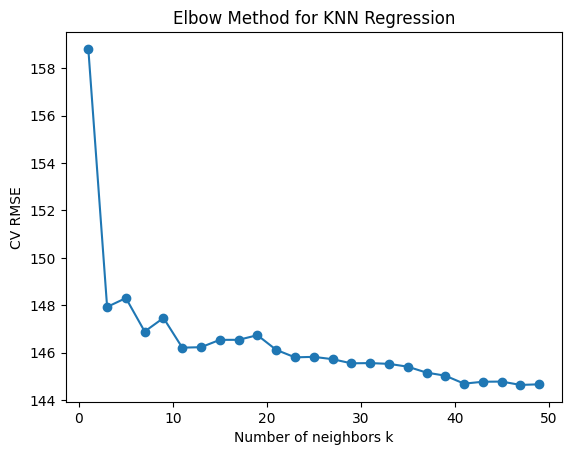

In [26]:
from sklearn.model_selection import cross_val_score

# Suppose X_train_scaled, y_train are ready
ks = range(1, 51, 2)         # odd k's from 1 to 29
rmse_scores = []

for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    # Note: cross_val_score with scoring='neg_mean_squared_error' returns negative MSE
    neg_mse = cross_val_score(knn, X_train_scaled, y_train_UTS,
                              cv=5,
                              scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse).mean()  
    rmse_scores.append(rmse)

plt.plot(ks, rmse_scores, marker='o')
plt.xlabel('Number of neighbors k')
plt.ylabel('CV RMSE')
plt.title('Elbow Method for KNN Regression')
plt.show()

### Results by KNN [for tensile strength]

In [27]:
## with new K=41
knn = KNeighborsRegressor(
    n_neighbors=6,       
    weights='distance',  
    metric='euclidean'  
)

knn.fit(X_train_scaled,y_train_UTS)

KNeighborsRegressor(metric='euclidean', n_neighbors=6, weights='distance')

In [28]:
## predicton & evaluation
y_pred = knn.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_UTS, y_pred))
print("R² :", r2_score(y_test_UTS, y_pred))

MSE: 17869.633279770787
R² : 0.5409288919399673


---
### So K=6 is best for tensile strength prediction by KNN
k = 6  </br>
**MSE: 17869.633279770787  </br>
R² : 0.5409288919399673**

---

k = 6  </br>
MSE: 17878.283139578616  </br>
R² : 0.5407066769306061 </br>
</br>
k = 5  </br>
MSE: 18086.11142307097  </br>
R² : 0.5353675656631658 </br>
</br>
k = 2  </br>
MSE: 18169.64646237108  </br>
R² : 0.5332215494325612 </br>
</br>
k = 3  </br>
MSE: 18537.893975460363 </br>
R² : 0.5237612661000755 </br>
</br>
k = 9  </br>
MSE: 18934.346954591634 </br>
R² : 0.5135763839833548 </br>
</br>
k = 11  </br>
MSE: 19429.944309160517 </br>
R² : 0.5008444815905333 </br>
</br>
k = 13 </br>
MSE: 19703.834475272226 </br>
R² : 0.49380823971163657 </br>

## KNN regression for Melting Point 

In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

knn = KNeighborsRegressor(
    n_neighbors=2,       
    weights='distance',  
    metric='euclidean'  
)

In [30]:
knn.fit(X_train_scaled, y_train_MC)

KNeighborsRegressor(metric='euclidean', n_neighbors=2, weights='distance')

In [31]:
## predicton & evaluation
y_pred = knn.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_MC, y_pred))
print("R² :", r2_score(y_test_MC, y_pred))

MSE: 23.418669574837438
R² : 0.9878886036677484


### Choosing the K value 

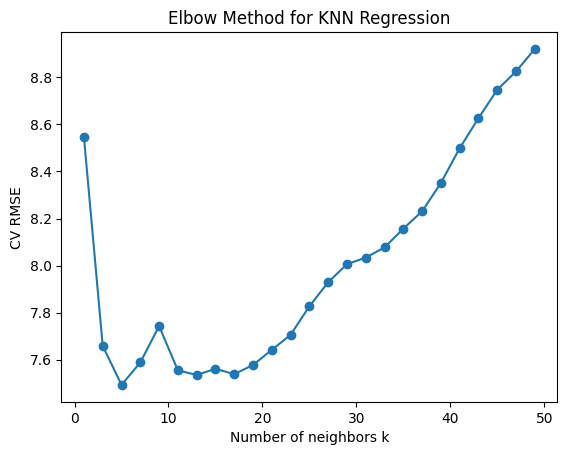

In [32]:
from sklearn.model_selection import cross_val_score

# Suppose X_train_scaled, y_train are ready
ks = range(1, 51, 2)         # odd k's from 1 to 29
rmse_scores = []

for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    # Note: cross_val_score with scoring='neg_mean_squared_error' returns negative MSE
    neg_mse = cross_val_score(knn, X_train_scaled, y_train_MC,
                              cv=5,
                              scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse).mean()  
    rmse_scores.append(rmse)

plt.plot(ks, rmse_scores, marker='o')
plt.xlabel('Number of neighbors k')
plt.ylabel('CV RMSE')
plt.title('Elbow Method for KNN Regression')
plt.show()

### Results by KNN [for Melting point completion]

In [33]:
## with new K=41
knn = KNeighborsRegressor(
    n_neighbors=5,       
    weights='distance',  
    metric='euclidean'  
)

knn.fit(X_train_scaled,y_train_MC)

KNeighborsRegressor(metric='euclidean', weights='distance')

In [34]:
## predicton & evaluation
y_pred = knn.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_MC, y_pred))
print("R² :", r2_score(y_test_MC, y_pred))

MSE: 21.551320917912165
R² : 0.9888543374214207


k = 2  </br>
MSE: 23.418669574837438  </br>
R² : 0.9878886036677484 </br>
</br>
k = 5  </br>
MSE: 21.551320917912165  </br>
R² : 0.9888543374214207 </br>
</br>
k = 2  </br>
MSE: 18169.64646237108  </br>
R² : 0.5332215494325612 </br>
</br>
k = 3  </br>
MSE: 18537.893975460363 </br>
R² : 0.5237612661000755 </br>
</br>
k = 9  </br>
MSE: 18934.346954591634 </br>
R² : 0.5135763839833548 </br>
</br>
k = 11  </br>
MSE: 19429.944309160517 </br>
R² : 0.5008444815905333 </br>
</br>
k = 13 </br>
MSE: 19703.834475272226 </br>
R² : 0.49380823971163657 </br>

---
### So K=5 is best for predicting Melting point completion by KNN
k = 5  </br>
**MSE: 21.551320917912165  </br>
R² : 0.9888543374214207**

---

# SVM - SVR

## SVR regression for Tensile Strength 

### *1. <u>**Kernel Linear***</u>

In [35]:
from sklearn.svm import SVR

svr_UTS = SVR(kernel='linear')

In [36]:
svr_UTS.fit(X_train_scaled, y_train_UTS)

SVR(kernel='linear')

In [37]:
## predicton & evaluation
y_pred = svr_UTS.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_UTS, y_pred))
print("R² :", r2_score(y_test_UTS, y_pred))

MSE: 31231.431994433584
R² : 0.1976641116515352


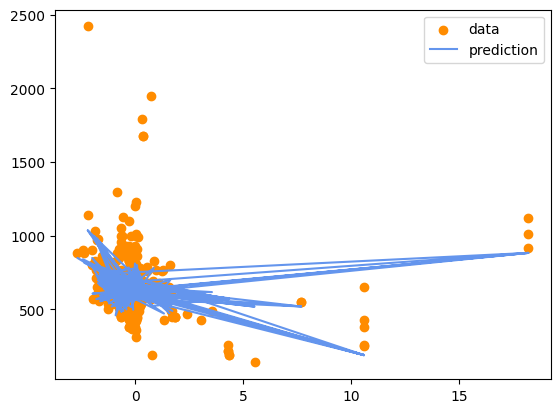

In [38]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_test_scaled)

# plot the predicted values against the true values
plt.scatter(pca_result[:, 0], y_test_UTS, color='darkorange',
            label='data')
plt.plot(pca_result[:, 0], y_pred, color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

---
### So For SVR with Linear Kernal - 
**MSE: 31231.431994433584  </br>
R² : 0.1976641116515352**

---

### *2. <u>**Kernel Polynomial***</u>

In [39]:
from sklearn.svm import SVR

svr_UTS_P = SVR(kernel='poly')

In [40]:
svr_UTS_P.fit(X_train_scaled, y_train_UTS)

SVR(kernel='poly')

In [41]:
## predicton & evaluation
y_pred = svr_UTS_P.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_UTS, y_pred))
print("R² :", r2_score(y_test_UTS, y_pred))

MSE: 31676.615432874532
R² : 0.18622734341038627


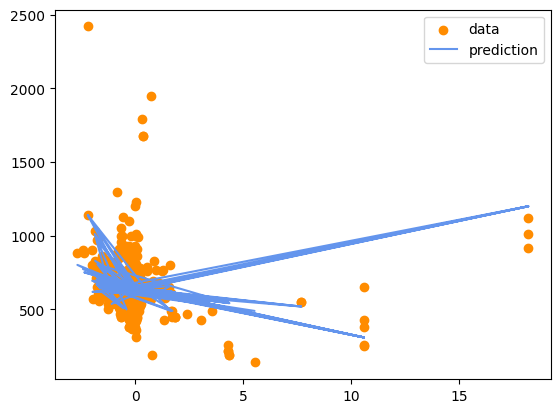

In [42]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_test_scaled)

# plot the predicted values against the true values
plt.scatter(pca_result[:, 0], y_test_UTS, color='darkorange',
            label='data')
plt.plot(pca_result[:, 0], y_pred, color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

***>>> hyperparameter Tuning >>>***

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm  # pip install tqdm if you don’t have it

param_grid = {
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

best_score = float('inf')
best_params = None

# Wrap ParameterGrid in tqdm for a progress bar
for params in tqdm(ParameterGrid(param_grid), total=len(ParameterGrid(param_grid)), desc="Grid Search"):
    model = SVR(kernel='poly', **params)
    # 5‑fold CV, minimizing MSE
    scores = cross_val_score(
        model,
        X_train_scaled, y_train_UTS,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1  # tqdm plays nicer without parallel forks
    )
    mean_mse = -scores.mean()
    
    if mean_mse < best_score:
        best_score = mean_mse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best CV MSE: {best_score:.4f}")


In [ ]:
# svr_UTS_R = SVR(kernel='poly', C=1000, epsilon=1, gamma=1)
# svr_UTS_R.fit(X_train_scaled, y_train_UTS)

# ## predicton & evaluation
# y_pred = svr_UTS_R.predict(X_test_scaled)
# print("MSE:", mean_squared_error(y_test_UTS, y_pred))
# print("R² :", r2_score(y_test_UTS, y_pred))

---
### So For SVR with Polynomial Kernal - 
**MSE: 31676.615432874532  </br>
R² : 0.18622734341038627**

---

### *3. <u>**Kernel RBF***</u>

In [43]:
from sklearn.svm import SVR

svr_UTS_R = SVR(kernel='rbf')

In [44]:
svr_UTS_R.fit(X_train_scaled, y_train_UTS)

SVR()

In [45]:
## predicton & evaluation
y_pred = svr_UTS_R.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_UTS, y_pred))
print("R² :", r2_score(y_test_UTS, y_pred))

MSE: 37114.44125615081
R² : 0.04652952829322454


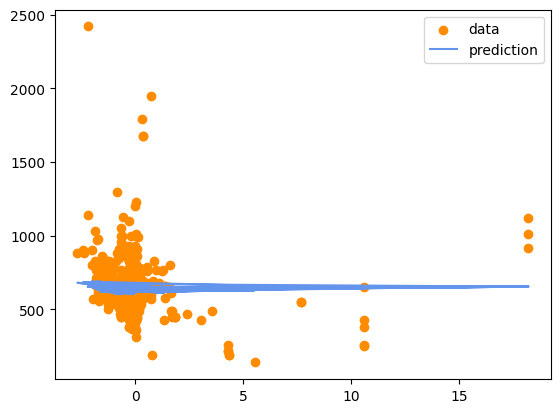

In [46]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_test_scaled)

# plot the predicted values against the true values
plt.scatter(pca_result[:, 0], y_test_UTS, color='darkorange',
            label='data')
plt.plot(pca_result[:, 0], y_pred, color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

***>>> hyperparameter Tuning >>>***

In [ ]:
from sklearn.svm import SVR
from tqdm import tqdm  # pip install tqdm if you don’t have it

param_grid = {
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

best_score = float('inf')
best_params = None

# Wrap ParameterGrid in tqdm for a progress bar
for params in tqdm(ParameterGrid(param_grid), total=len(ParameterGrid(param_grid)), desc="Grid Search"):
    model = SVR(kernel='rbf', **params)
    # 5‑fold CV, minimizing MSE
    scores = cross_val_score(
        model,
        X_train_scaled, y_train_UTS,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1  # tqdm plays nicer without parallel forks
    )
    mean_mse = -scores.mean()
    
    if mean_mse < best_score:
        best_score = mean_mse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best CV MSE: {best_score:.4f}")


In [47]:
svr_UTS_R = SVR(kernel='rbf', C=1000, epsilon=1, gamma=1)
svr_UTS_R.fit(X_train_scaled, y_train_UTS)

## predicton & evaluation
y_pred = svr_UTS_R.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_UTS, y_pred))
print("R² :", r2_score(y_test_UTS, y_pred))

MSE: 22915.964451719396
R² : 0.4112885794346819


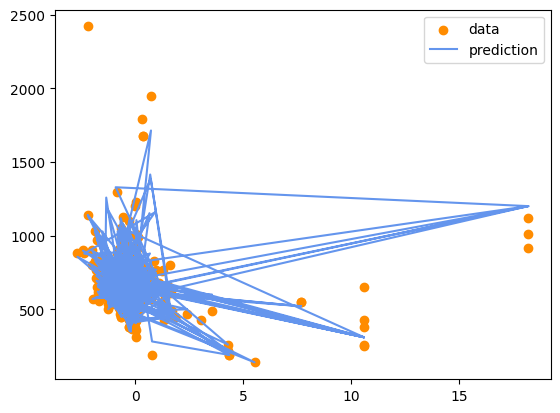

In [48]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_test_scaled)

# plot the predicted values against the true values
plt.scatter(pca_result[:, 0], y_test_UTS, color='darkorange',
            label='data')
plt.plot(pca_result[:, 0], y_pred, color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

---
### So For SVR with RBF Kernal - 
**MSE: 22915.964451719396  </br>
R² : 0.4112885794346819**

---

## SVR regression for Melting Point 

### *1. <u>**Kernel Linear***</u>

In [49]:
from sklearn.svm import SVR

svr_MC = SVR(kernel='linear')

In [50]:
svr_MC.fit(X_train_scaled, y_train_MC)

SVR(kernel='linear')

In [51]:
## predicton & evaluation
y_pred = svr_MC.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_MC, y_pred))
print("R² :", r2_score(y_test_MC, y_pred))

MSE: 165.2471898086325
R² : 0.9145393720096908


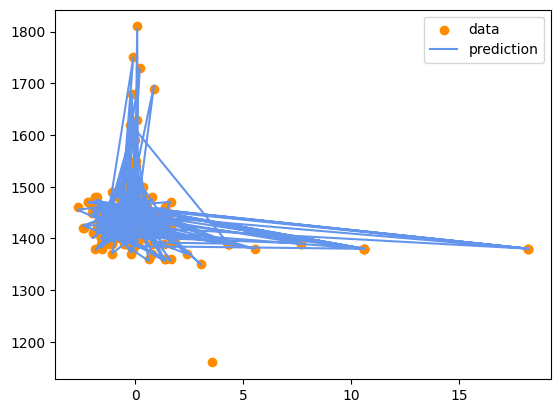

In [52]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_test_scaled)

# plot the predicted values against the true values
plt.scatter(pca_result[:, 0], y_test_MC, color='darkorange',
            label='data')
plt.plot(pca_result[:, 0], y_pred, color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

---
### So For SVR with Linear Kernal - 
**MSE: 165.2471898086325  </br>
R² : 0.9145393720096908**

---

### *2. <u>**Kernel Polynomial***</u>

In [53]:
from sklearn.svm import SVR

svr_MC_P = SVR(kernel='poly')

In [54]:
svr_MC_P.fit(X_train_scaled, y_train_MC)

SVR(kernel='poly')

In [55]:
## predicton & evaluation
y_pred = svr_MC_P.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_MC, y_pred))
print("R² :", r2_score(y_test_MC, y_pred))

MSE: 643.3874079957459
R² : 0.6672603510410722


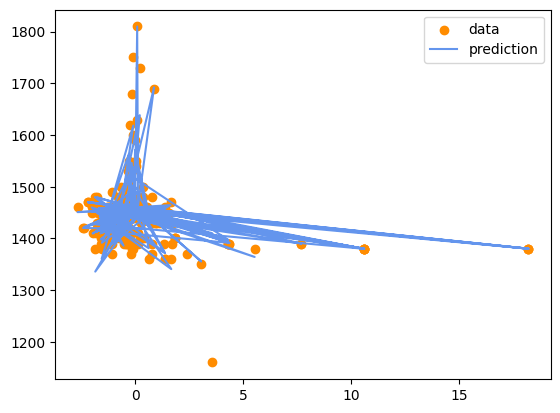

In [56]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_test_scaled)

# plot the predicted values against the true values
plt.scatter(pca_result[:, 0], y_test_MC, color='darkorange',
            label='data')
plt.plot(pca_result[:, 0], y_pred, color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

---
### So For SVR with Polynomial Kernal - 
**MSE: 643.3874079957459  </br>
R² : 0.6672603510410722**

---

### *3. <u>**Kernel RBF***</u>

In [57]:
from sklearn.svm import SVR

svr_MC_R = SVR(kernel='rbf')

In [58]:
svr_MC_R.fit(X_train_scaled, y_train_MC)

SVR()

In [59]:
## predicton & evaluation
y_pred = svr_MC_R.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_MC, y_pred))
print("R² :", r2_score(y_test_MC, y_pred))

MSE: 1262.119984815519
R² : 0.3472714021559776


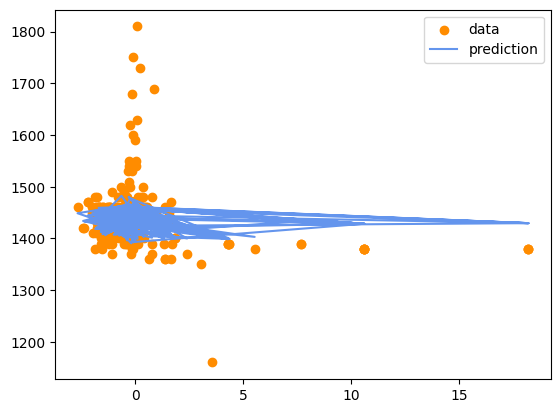

In [60]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_test_scaled)

# plot the predicted values against the true values
plt.scatter(pca_result[:, 0], y_test_MC, color='darkorange',
            label='data')
plt.plot(pca_result[:, 0], y_pred, color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

***>>> hyperparameter Tuning >>>***

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm  # pip install tqdm if you don’t have it

param_grid = {
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

best_score = float('inf')
best_params = None

# Wrap ParameterGrid in tqdm for a progress bar
for params in tqdm(ParameterGrid(param_grid), total=len(ParameterGrid(param_grid)), desc="Grid Search"):
    model = SVR(kernel='rbf', **params)
    # 5‑fold CV, minimizing MSE
    scores = cross_val_score(
        model,
        X_train_scaled, y_train_MC,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1  # tqdm plays nicer without parallel forks
    )
    mean_mse = -scores.mean()
    
    if mean_mse < best_score:
        best_score = mean_mse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best CV MSE: {best_score:.4f}")


In [61]:
svr_MC_R = SVR(kernel='rbf', C=1000, epsilon=1, gamma='auto')
svr_MC_R.fit(X_train_scaled, y_train_MC)

## predicton & evaluation
y_pred = svr_MC_R.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test_MC, y_pred))
print("R² :", r2_score(y_test_MC, y_pred))

MSE: 62.90977792818268
R² : 0.967465049573917


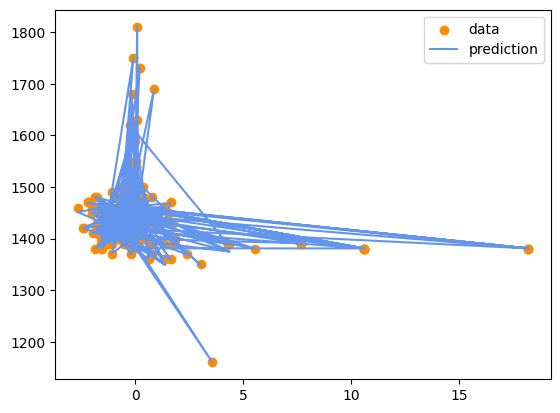

In [62]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_test_scaled)

# plot the predicted values against the true values
plt.scatter(pca_result[:, 0], y_test_MC, color='darkorange',
            label='data')
plt.plot(pca_result[:, 0], y_pred, color='cornflowerblue',
         label='prediction')
plt.legend()
plt.show()

---
### So For SVR with RBF Kernal - 
**MSE: 62.90977792818268  </br>
R² : 0.967465049573917**

---

# ANN 

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
X_train_np = np.asarray(X_train_scaled)
X_test_np  = np.asarray(X_test_scaled)

y_train_uts_np = np.asarray(y_train_UTS)
y_train_mc_np = np.asarray(y_train_MC)
y_test_uts_np  = np.asarray(y_test_UTS)
y_test_mc_np  = np.asarray(y_test_MC)

# Stack train targets for multi-output
y_train_np = np.stack([y_train_uts_np, y_train_mc_np], axis=1)

# Convert to torch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)  # shape (N, 2)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test_UTS = torch.tensor(y_test_uts_np, dtype=torch.float32).unsqueeze(1)
y_test_MC = torch.tensor(y_test_mc_np, dtype=torch.float32).unsqueeze(1)


X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(
    np.stack([y_train_UTS, y_train_MC], axis=1),
    dtype=torch.float32
)  # shape (N, 2)

X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_UTS = torch.tensor(y_test_UTS, dtype=torch.float32).unsqueeze(1)
y_test_MC = torch.tensor(y_test_MC, dtype=torch.float32).unsqueeze(1)

# Create dataloaders
train_ds_multi = TensorDataset(X_train, y_train)
train_loader_multi = DataLoader(train_ds_multi, batch_size=32, shuffle=True)

train_ds_separate = TensorDataset(X_train, y_train)
train_loader_sep = DataLoader(train_ds_separate, batch_size=32, shuffle=True)


### *1. <u>**Multi-Output ANN***</u>

In [ ]:
class MultiOutputNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
model_multi = MultiOutputNet(input_dim=X_train.shape[1])
optimizer_m = optim.Adam(model_multi.parameters(), lr=1e-3)
criterion_m = nn.MSELoss()

In [ ]:
# Training loop
for epoch in range(1, 1001):
    model_multi.train()
    running_loss = 0.0
    for xb, yb in train_loader_multi:
        optimizer_m.zero_grad()
        preds = model_multi(xb)
        loss = criterion_m(preds, yb)
        loss.backward()
        optimizer_m.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader_multi.dataset)
    if epoch % 10 == 0:
        print(f"[Multi] Epoch {epoch:03d} | Loss: {epoch_loss:.4f}")

***>>lowering the Learning Rate >>***

In [ ]:
optimizer_m = optim.Adam(model_multi.parameters(), lr=5e-4)
# Training loop
for epoch in range(1, 5001):
    model_multi.train()
    running_loss = 0.0
    for xb, yb in train_loader_multi:
        optimizer_m.zero_grad()
        preds = model_multi(xb)
        loss = criterion_m(preds, yb)
        loss.backward()
        optimizer_m.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader_multi.dataset)
    if epoch % 10 == 0:
        print(f"[Multi] Epoch {epoch:03d} | Loss: {epoch_loss:.4f}")

In [ ]:
## Evalutaion 
model_multi.eval()
with torch.no_grad():
    y_pred_multi = model_multi(X_test).numpy()

mse_uts_m = mean_squared_error(y_test_UTS.ravel(), y_pred_multi[:, 0])
r2_uts_m = r2_score(y_test_UTS.ravel(), y_pred_multi[:, 0])
mse_mc_m = mean_squared_error(y_test_MC.ravel(), y_pred_multi[:, 1])
r2_mc_m = r2_score(y_test_MC.ravel(), y_pred_multi[:, 1])

print("[MultiOutputNet] UTS  - MSE:", mse_uts_m, " R²:", r2_uts_m)
print("[MultiOutputNet] Melting Point  - MSE:", mse_mc_m, " R²:", r2_mc_m)

---
### So For Multi-Output ANN BEST Results are - 
**UTS  - MSE: 20628.879   ---  R²: 0.47004383338986255  </br>
Melting Point  - MSE: 117.006996 --- R²: 0.9394876778443838**

---

### *1. <u>**sINGLE-Output ANN***</u>

In [ ]:
class SingleOutputNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# UTS model
model_UTS = SingleOutputNet(input_dim=X_train.shape[1])
optimizer_u = optim.Adam(model_UTS.parameters(), lr=1e-3)
criterion_u = nn.MSELoss()

In [ ]:
# Melting point Completion model
model_MC = SingleOutputNet(input_dim=X_train.shape[1])
optimizer_l = optim.Adam(model_MC.parameters(), lr=1e-3)
criterion_l = nn.MSELoss()

In [ ]:
# Training loop for separate models
for epoch in range(1, 101):
    model_UTS.train()
    model_MC.train()
    running_u = 0.0
    running_l = 0.0
    for xb, yb in train_loader_sep:
        # UTS
        optimizer_u.zero_grad()
        pred_u = model_UTS(xb)
        loss_u = criterion_u(pred_u, yb[:, 0:1])
        loss_u.backward()
        optimizer_u.step()
        running_u += loss_u.item() * xb.size(0)

        # MC
        optimizer_l.zero_grad()
        pred_l = model_MC(xb)
        loss_l = criterion_l(pred_l, yb[:, 1:2])
        loss_l.backward()
        optimizer_l.step()
        running_l += loss_l.item() * xb.size(0)

    if epoch % 10 == 0:
        avg_u = running_u / len(train_loader_sep.dataset)
        avg_l = running_l / len(train_loader_sep.dataset)
        print(f"[Separate] Epoch {epoch:03d} | UTS Loss: {avg_u:.4f} | MC Loss: {avg_l:.4f}")


In [ ]:
optimizer_l = optim.Adam(model_MC.parameters(), lr=1e-4)
# Training loop for separate models
for epoch in range(1, 1001):
    model_UTS.train()
    model_MC.train()
    running_u = 0.0
    running_l = 0.0
    for xb, yb in train_loader_sep:
        # UTS
        optimizer_u.zero_grad()
        pred_u = model_UTS(xb)
        loss_u = criterion_u(pred_u, yb[:, 0:1])
        loss_u.backward()
        optimizer_u.step()
        running_u += loss_u.item() * xb.size(0)

        # MC
        optimizer_l.zero_grad()
        pred_l = model_MC(xb)
        loss_l = criterion_l(pred_l, yb[:, 1:2])
        loss_l.backward()
        optimizer_l.step()
        running_l += loss_l.item() * xb.size(0)

    if epoch % 10 == 0:
        avg_u = running_u / len(train_loader_sep.dataset)
        avg_l = running_l / len(train_loader_sep.dataset)
        print(f"[Separate] Epoch {epoch:03d} | UTS Loss: {avg_u:.4f} | MC Loss: {avg_l:.4f}")


In [ ]:
## Evaluate
model_UTS.eval()
model_MC.eval()
with torch.no_grad():
    y_pred_u = model_UTS(X_test).numpy()
    y_pred_mc = model_MC(X_test).numpy()

mse_uts_s = mean_squared_error(y_test_UTS.ravel(), y_pred_u)
r2_uts_s = r2_score(y_test_UTS.ravel(), y_pred_u)
mse_mc_s = mean_squared_error(y_test_MC.ravel(), y_pred_mc)
r2_mc_s = r2_score(y_test_MC.ravel(), y_pred_mc)

print("[Separate UTS Net]  UTS  - MSE:", mse_uts_s, " R²:", r2_uts_s)
print("[Separate MC Net]  MC  - MSE:", mse_mc_s, " R²:", r2_mc_s)

---
### So For Single-Output ANN Best results are- 
**UTS  - MSE: 19426.287 --- R²: 0.5009383542476336  </br>
Melting Point  - MSE: 77.04037 --- R²: 0.960157157422803**

---